# Проект "Определение токсичности англоязычных комментариев"

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**План работы над проектом**

1. Загрузить и подготовьть данные.
2. Обучить разные модели. 
3. Сделать выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import re
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns

from  sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from  sklearn.metrics import f1_score
from  sklearn.pipeline import Pipeline
from  sklearn.ensemble import RandomForestClassifier
from  sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
tqdm.pandas()

from spacy.lang.en import English
from nltk.probability import FreqDist
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import stopwords

import nltk

In [3]:
try:

    data = pd.read_csv('С:/your_project/toxic_comments.csv')
except:

    data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)

print(data.sample)

<bound method NDFrame.sample of                                                      text  toxic
0       Explanation\nWhy the edits made under my usern...      0
1       D'aww! He matches this background colour I'm s...      0
2       Hey man, I'm really not trying to edit war. It...      0
3       "\nMore\nI can't make any real suggestions on ...      0
4       You, sir, are my hero. Any chance you remember...      0
...                                                   ...    ...
159446  ":::::And for the second time of asking, when ...      0
159447  You should be ashamed of yourself \n\nThat is ...      0
159448  Spitzer \n\nUmm, theres no actual article for ...      0
159449  And it looks like it was actually you who put ...      0
159450  "\nAnd ... I really don't think you understand...      0

[159292 rows x 2 columns]>


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None


In [5]:
data['toxic'].value_counts()#посмотрим на количество строк с разными классами, классы очень не сбалансированы в сторону 0

0    143106
1     16186
Name: toxic, dtype: int64

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


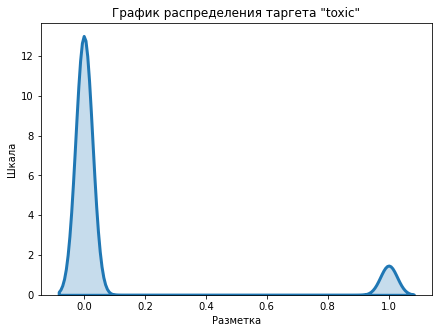

In [6]:
plt.figure(figsize=(7, 5))#построим график распределения для таргета, чтобы наглядно увидеть разницу бинарной классификации
sns.distplot(data['toxic'], hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 3})

plt.title('График распределения таргета "toxic"')
plt.xlabel('Разметка')
plt.ylabel('Шкала')
plt.show()

In [7]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

en_core = spacy.load('en_core_web_sm')

def lemmatize(text): #напишем функцию лемматизации для английского текста
    text = text.lower()   
    return " ".join([token.lemma_ for token in en_core(text)])

def clear_text(text): #напишем функцию для очистки текста
    text = re.sub(r'[^a-zA-Z ]', " ", text)
    y = " ".join(text.split())
    return y

data['text'] = data['text'].progress_apply(clear_text)#перепишем столбец применив функции

data['text'] = data['text'].progress_apply(lemmatize)


print('Очищенный и лемматизированный текст:', data.sample)

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

Очищенный и лемматизированный текст: <bound method NDFrame.sample of                                                      text  toxic
0       explanation why the edit make under my usernam...      0
1       d aww he match this background colour I m seem...      0
2       hey man I m really not try to edit war it s ju...      0
3       more I can t make any real suggestion on impro...      0
4       you sir be my hero any chance you remember wha...      0
...                                                   ...    ...
159446  and for the second time of ask when your view ...      0
159447  you should be ashamed of yourself that be a ho...      0
159448  spitzer umm there s no actual article for pros...      0
159449  and it look like it be actually you who put on...      0
159450  and I really don t think you understand I come...      0

[159292 rows x 2 columns]>


In [8]:
corpus = list(data['text'])

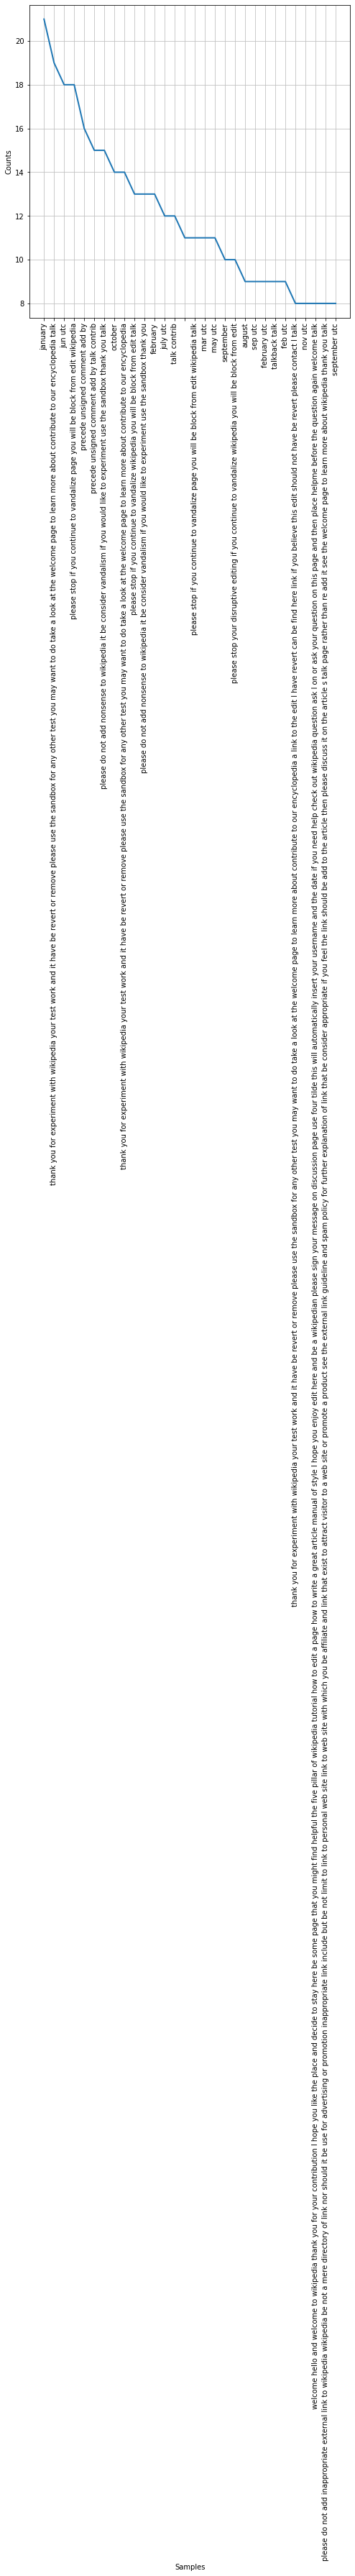

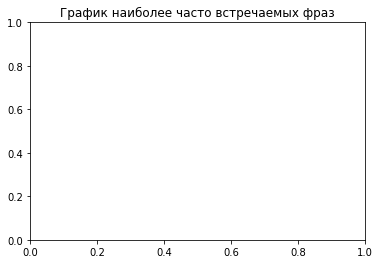

In [9]:
fdist = FreqDist(corpus)
plt.figure(figsize=(8, 8))
fdist.plot(30, cumulative=False)
plt.title('График наиболее часто встречаемых фраз')
plt.show()

In [10]:
features = data['text']#выделим признаки и целевой признак
target = data['toxic']

In [11]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.30, random_state = 12345, stratify=target)#разделим выборки

In [12]:
stopwords = set(nltk_stopwords.words('english'))#применим стопслова

In [13]:
print(features_train.shape)
print(features_test.shape)

(111504,)
(47788,)


___Комментарии:___ Мы подготовили данные для обучения модели, очистили и лемматизировали английский текст, применили величины TF-IDF как признаки. Далее обучим на признаках несколько моделей для классификации.

## Обучение

In [14]:
%%time


pipeline = Pipeline([('tvect', CountVectorizer(stop_words=stopwords, binary=True)),
                     ('tfidf', TfidfTransformer()),
                     ('model', RandomForestClassifier(random_state=12345, class_weight='balanced'))])

model = GridSearchCV(
    estimator = pipeline, param_grid = {'tfidf__use_idf': [True, False]}, n_jobs=-1, scoring='f1', cv=5, verbose=3)

model.fit(features_train, target_train)


print('F1 на тренировочной выборке модели RandomForestClassifier:', model.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ............................tfidf__use_idf=True; total time= 6.9min
[CV 2/5] END ............................tfidf__use_idf=True; total time= 7.0min
[CV 3/5] END ............................tfidf__use_idf=True; total time= 8.5min
[CV 4/5] END ............................tfidf__use_idf=True; total time= 8.4min
[CV 5/5] END ............................tfidf__use_idf=True; total time= 8.5min
[CV 1/5] END ...........................tfidf__use_idf=False; total time= 8.2min
[CV 2/5] END ...........................tfidf__use_idf=False; total time= 7.4min
[CV 3/5] END ...........................tfidf__use_idf=False; total time= 8.2min
[CV 4/5] END ...........................tfidf__use_idf=False; total time= 8.2min
[CV 5/5] END ...........................tfidf__use_idf=False; total time= 8.3min
F1 на тренировочной выборке модели RandomForestClassifier: 0.6224684604661082
CPU times: user 1h 30min 18s, sys: 13.6 s, total: 1h

In [15]:
%%time

pipeline = Pipeline([('vect', CountVectorizer(stop_words=stopwords, binary=True)),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression(random_state=12345, class_weight='balanced', solver='lbfgs', max_iter=500))])

params =  {
    'vect__max_df': (0.5, 0.75, 1.0),
    'tfidf__use_idf': (True, False)
}

grid = GridSearchCV(pipeline, params, n_jobs = -1, scoring = 'f1', cv=3)

grid.fit(features_train, target_train)

print('F1 на тренировочной выборке модели LogisticRegression:', grid.best_score_)

F1 на тренировочной выборке модели LogisticRegression: 0.7462335498084715
CPU times: user 7min 26s, sys: 7min 43s, total: 15min 10s
Wall time: 15min 11s


In [16]:
prediction = grid.predict(features_test)
f1 = f1_score(target_test, prediction)
print('F1 на тестовой выборке LogisticRegression:', f1)

F1 на тестовой выборке LogisticRegression: 0.7603186097031137


## Выводы

Мы обучили моедль классифицировать комментарии на позитивные и негативные. Мы построили разные модели - RandomForestClassifier,  LogisticRegression со значением метрики качества F1, RandomForestClassifier сработало хуже, метрика F1 0.62 на тренировочной выборке, следователоьно мы применили на тестовой выборке модель LogisticRegression значением f1 - 0,76.